## Loss ablation for an NHANES model

**Question of interest: Does loss ablation improve for loss explanations in comparison to output explanations**?

In [4]:
from sklearn.metrics import log_loss, roc_auc_score
from xgboost import XGBClassifier

import matplotlib.pylab as plt
import numpy as np

import matplotlib
import pickle
import shap
import os

from deepshap.data import load_nhanes_new

# Name of experiment we are running
exp_name = "cycle_shift"

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_nhanes_new()

# Train or load model
mpath = "models/{}_xgb.p".format(exp_name)
if not os.path.exists(mpath):
    model = XGBClassifier()
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
              early_stopping_rounds=10, verbose=False)
    pickle.dump(model, open(mpath,"wb"))
else:
    model = pickle.load(open(mpath,"rb"))
    
# Evaluate model performance
print("Train ROC AUC ", roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
print("Test ROC AUC  ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print("Train loss    ", log_loss(y_train, model.predict_proba(X_train)[:,1]))
print("Test loss     ", log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train ROC AUC  0.9882752748310369
Test ROC AUC   0.8681190191906044
Train loss     0.08771404129969228
Test loss      0.26650387368177847


### Load/compute attributions

In [38]:
from deepshap.explanation import lime_wrapper
import pandas as pd

def log_loss_per_sample(ytrue, ypred):
    """
    log_loss computation that does not fail if all labels are the same
    """
    return((-(ytrue*np.log(ypred)+(1-ytrue)*np.log(1-ypred))))

def log_loss_safe(ytrue, ypred):
    """
    log_loss computation that does not fail if all labels are the same
    """
    return(log_loss_per_sample(ytrue, ypred))

def loss_fn_neg(x): 
    x_df = pd.DataFrame(x, columns=X_train.columns)
    return(log_loss_safe(np.zeros(x.shape[0]), model.predict_proba(x_df)[:,1]))

def loss_fn_pos(x): 
    x_df = pd.DataFrame(x, columns=X_train.columns)
    return(log_loss_safe(np.ones(x.shape[0]), model.predict_proba(x_df)[:,1]))

In [139]:
x_explic = X_train[0:1000]
y_explic = y_train[0:1000]
# Need to repeat to same shape as x_explic

np.random.seed(102190)
rand_inds = np.random.choice(range(X_train.shape[0]), 1000, replace=False)
reference = X_train.iloc[rand_inds]

x_explic_pos = x_explic[y_explic==1]
y_explic_pos = y_explic[y_explic==1]

x_explic_neg = x_explic[y_explic==0]
y_explic_neg = y_explic[y_explic==0]

loss_pos = loss_fn_pos(x_explic_pos)
loss_neg = loss_fn_neg(x_explic_neg)

# Verify that the mean loss matches
np.allclose(np.hstack([loss_pos,loss_neg]).mean(),
            log_loss(y_explic, model.predict_proba(x_explic)[:,1]))

True

### Compute or load attributions

In [212]:
deep_attr_name   = "attr/{}_train1000_loss_attr_deep.npy".format(exp_name)
sample_attr_name = "attr/{}_train1000_loss_attr_sampling.npy".format(exp_name)
kernel_attr_name = "attr/{}_train1000_loss_attr_kernel.npy".format(exp_name)
lime_attr_name   = "attr/{}_train1000_loss_attr_lime.npy".format(exp_name)
runtimes_name    = "attr/{}_expl_times_1000.p".format(exp_name)
attr_names = [deep_attr_name, sample_attr_name, kernel_attr_name, lime_attr_name, runtime_names]

if all([os.path.exists(name) for name in attr_names]):
    # DeepSHAP attributions
    start = time()
    loss_explainer = shap.TreeExplainer(model, data=reference, model_output="log_loss")
    attr_deep = loss_explainer.shap_values(X_train[0:1000], y_train[0:1000])
    deep_expl_time = time() - start
    np.save(deep_attr_name, attr_deep)

    # SamplingExplainer attributions
    start = time()
    explanation_fn = shap.SamplingExplainer
    explainer_pos  = explanation_fn(loss_fn_pos, reference)
    attr_pos       = explainer_pos.shap_values(x_explic_pos, num_samples=1000)

    explainer_neg  = explanation_fn(loss_fn_neg, reference)
    attr_neg       = explainer_neg.shap_values(x_explic_neg, num_samples=1000)
    sampling_expl_time = time() - start

    attr_sample = np.zeros([1000,153])
    attr_sample[y_train[0:1000]==1] = attr_pos
    attr_sample[y_train[0:1000]==0] = attr_neg
    np.save(sample_attr_name, attr_sample)

    # KernelExplainer attributions
    start = time()
    explanation_fn = shap.KernelExplainer
    explainer_pos  = explanation_fn(loss_fn_pos, reference)
    attr_pos       = explainer_pos.shap_values(x_explic_pos, num_samples=1000)

    explainer_neg  = explanation_fn(loss_fn_neg, reference)
    attr_neg       = explainer_neg.shap_values(x_explic_neg, num_samples=1000)
    kernel_expl_time = time() - start

    attr_kernel = np.zeros([1000,153])
    attr_kernel[y_train[0:1000]==1] = attr_pos
    attr_kernel[y_train[0:1000]==0] = attr_neg
    np.save(kernel_attr_name, attr_kernel)

    # LIME attributions
    start = time()
    attr_pos = lime_wrapper(loss_fn_pos, x_explic_pos.values, 
                            reference, mode="regression", 
                            wrap_pred=False, num_samples=1000)

    attr_neg = lime_wrapper(loss_fn_neg, x_explic_neg.values, 
                            reference, mode="regression", 
                            wrap_pred=False, num_samples=1000)
    lime_expl_time = time() - start

    attr_lime = np.zeros([1000,153])
    attr_lime[y_train[0:1000]==1] = attr_pos
    attr_lime[y_train[0:1000]==0] = attr_neg
    np.save(lime_attr_name, attr_lime)

    expl_times = {"deep":deep_expl_time, "sample":sampling_expl_time, 
                  "kernel":kernel_expl_time, "lime":lime_expl_time}
    pickle.dump(expl_times, open(runtimes_name, "wb"))
else:
    attr_deep   = np.load(deep_attr_name)
    attr_sample = np.load(sample_attr_name)
    attr_kernel = np.load(kernel_attr_name)
    attr_lime   = np.load(lime_attr_name)
    
    expl_times  = pickle.load(open(runtimes_name, "rb"))
    deep_expl_time     = expl_times["deep"]
    sampling_expl_time = expl_times["sample"]
    kernel_expl_time   = expl_times["kernel"]
    lime_expl_time     = expl_times["lime"]

True

In [ ]:
from time import time

# DeepSHAP attributions
start = time()
loss_explainer = shap.TreeExplainer(model, data=reference, model_output="log_loss")
attr_deep = loss_explainer.shap_values(X_train[0:1000], y_train[0:1000])
deep_expl_time = time() - start

np.save("attr/{}_train1000_loss_attr_deep.npy".format(exp_name), attr_deep)

# SamplingExplainer attributions
start = time()
explanation_fn = shap.SamplingExplainer
explainer_pos  = explanation_fn(loss_fn_pos, reference)
attr_pos       = explainer_pos.shap_values(x_explic_pos, num_samples=1000)

explainer_neg  = explanation_fn(loss_fn_neg, reference)
attr_neg       = explainer_neg.shap_values(x_explic_neg, num_samples=1000)
sampling_expl_time = time() - start

attr_sample = np.zeros([1000,153])
attr_sample[y_train[0:1000]==1] = attr_pos
attr_sample[y_train[0:1000]==0] = attr_neg
np.save("attr/{}_train1000_loss_attr_sampling.npy".format(exp_name), attr_sample)

# KernelExplainer attributions
start = time()
explanation_fn = shap.KernelExplainer
explainer_pos  = explanation_fn(loss_fn_pos, reference)
attr_pos       = explainer_pos.shap_values(x_explic_pos, num_samples=1000)

explainer_neg  = explanation_fn(loss_fn_neg, reference)
attr_neg       = explainer_neg.shap_values(x_explic_neg, num_samples=1000)
kernel_expl_time = time() - start

attr_kernel = np.zeros([1000,153])
attr_kernel[y_train[0:1000]==1] = attr_pos
attr_kernel[y_train[0:1000]==0] = attr_neg
np.save("attr/{}_train1000_loss_attr_kernel.npy".format(exp_name), attr_kernel)

# LIME attributions
start = time()
attr_pos = lime_wrapper(loss_fn_pos, x_explic_pos.values, 
                        reference, mode="regression", 
                        wrap_pred=False, num_samples=1000)

attr_neg = lime_wrapper(loss_fn_neg, x_explic_neg.values, 
                        reference, mode="regression", 
                        wrap_pred=False, num_samples=1000)
lime_expl_time = time() - start

attr_lime = np.zeros([1000,153])
attr_lime[y_train[0:1000]==1] = attr_pos
attr_lime[y_train[0:1000]==0] = attr_neg
np.save("attr/{}_train1000_loss_attr_lime.npy".format(exp_name), attr_lime)

expl_times = {"deep":deep_expl_time, "sample":sampling_expl_time, 
              "kernel":kernel_expl_time, "lime":lime_expl_time}
pickle.dump(expl_times, open("attr/{}_expl_times_1000.p".format(exp_name), "wb"))

In [62]:
###############################
### Get output attributions ###
###############################
train_attr_path = "attr/{}_train_attr.npy".format(exp_name)
test_attr_path  = "attr/{}_test_attr.npy".format(exp_name)

np.random.seed(102190)
rand_inds = np.random.choice(range(X_train.shape[0]), 1000, replace=False)
reference = X_train.iloc[rand_inds]

explainer = shap.TreeExplainer(model, data=reference)
if not (os.path.exists(train_attr_path) and os.path.exists(test_attr_path)):
    train_attr = explainer.shap_values(X_train)
    test_attr  = explainer.shap_values(X_test)
    
    np.save(train_attr_path, train_attr)
    np.save(test_attr_path, test_attr)
else:
    train_attr = np.load(train_attr_path)
    test_attr  = np.load(test_attr_path)

#############################
### Get loss attributions ###
#############################
train_loss_attr_path = "attr/{}_train_loss_attr.npy".format(exp_name)
test_loss_attr_path  = "attr/{}_test_loss_attr.npy".format(exp_name)

loss_explainer = shap.TreeExplainer(model, data=reference, model_output="log_loss")
if not (os.path.exists(train_loss_attr_path) and os.path.exists(test_loss_attr_path)):
    train_loss_attr = loss_explainer.shap_values(X_train, y_train)
    test_loss_attr  = loss_explainer.shap_values(X_test, y_test)
    
    np.save(train_loss_attr_path, train_loss_attr)
    np.save(test_loss_attr_path, test_loss_attr)
else:
    train_loss_attr = np.load(train_loss_attr_path)
    test_loss_attr  = np.load(test_loss_attr_path)

### Ablation

In [30]:
from deepshap.evaluation import ablate
import pandas as pd
plt.rcParams['figure.figsize'] = 4,4

def loss_fn(x, y): 
    x_df = pd.DataFrame(x, columns=x_explic.columns)
    return(log_loss(y, model.predict_proba(x_df)[:,1]))

x_explic = X_train[0:1000]
y_explic = y_train[0:1000]
# Need to repeat to same shape as x_explic
refer = np.repeat(np.array(x_explic.mean(0))[np.newaxis,:],1000,0) 

##################################
### Ablate OUTPUT attributions ###
##################################
attr = train_attr[0:1000]

### Positive ###
ablated_loss = ablate(loss_fn, attr, x_explic, impute="pos", 
                      refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss, linewidth=3)
plt.title("Ablate Positive Output")
plt.ylabel("Mean Loss")
plt.xlabel("Number of Features Ablated")
plt.savefig("fig/{}_ablate_pos_out.pdf".format(exp_name))
plt.show()

### Negative ###
ablated_loss = ablate(loss_fn, attr, x_explic, impute="neg", 
                      refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss, linewidth=3)
plt.title("Ablate Negative Output")
plt.ylabel("Mean Loss")
plt.xlabel("Number of Features Ablated")
plt.savefig("fig/{}_ablate_neg_out.pdf".format(exp_name))
plt.show()

################################
### Ablate LOSS attributions ###
################################
GREEN  = "#1ea81e"
BLUE   = "#1e88e5"
RED    = "#ff0d57"
ORANGE = "#ff8800"

### Positive ###
ablated_loss_deep = ablate(loss_fn, attr_deep, x_explic, impute="pos", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_deep, linewidth=3, label="DeepSHAP", color=BLUE)
ablated_loss_sample = ablate(loss_fn, attr_sample, x_explic, impute="pos", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_sample, linewidth=3, label="IME", color=ORANGE)
ablated_loss_kernel = ablate(loss_fn, attr_kernel, x_explic, impute="pos", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_kernel, linewidth=3, label="Kernel", color=GREEN)
ablated_loss_lime = ablate(loss_fn, attr_lime, x_explic, impute="pos", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_lime, linewidth=3, label="LIME", color=RED)

plt.title("Ablate Positive Loss")
plt.ylabel("Mean Loss")
plt.xlabel("Number of Features Ablated")
plt.legend()
plt.savefig("fig/{}_ablate_pos_loss.pdf".format(exp_name))
plt.show()

### Negative ###
ablated_loss_deep = ablate(loss_fn, attr_deep, x_explic, impute="neg", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_deep, linewidth=3, label="DeepSHAP", color=BLUE)
ablated_loss_sample = ablate(loss_fn, attr_sample, x_explic, impute="neg", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_sample, linewidth=3, label="IME", color=ORANGE)
ablated_loss_kernel = ablate(loss_fn, attr_kernel, x_explic, impute="neg", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_kernel, linewidth=3, label="Kernel", color=GREEN)
ablated_loss_lime = ablate(loss_fn, attr_lime, x_explic, impute="neg", 
                             refer=refer, y_explic=y_explic, is_loss=True)
plt.plot(ablated_loss_lime, linewidth=3, label="LIME", color=RED)

# ablated_loss = ablate(loss_fn, attr, x_explic, impute="neg", 
#                       refer=refer, y_explic=y_explic, is_loss=True)
# plt.plot(ablated_loss, linewidth=3)
plt.title("Ablate Negative Loss")
plt.ylabel("Mean Loss")
plt.xlabel("Number of Features Ablated")
plt.legend()
plt.savefig("fig/{}_ablate_neg_loss.pdf".format(exp_name))
plt.show()

NameError: name 'train_attr' is not defined

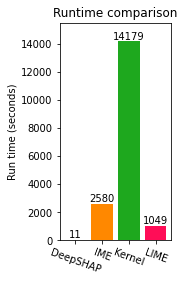

In [218]:
plt.rcParams['figure.figsize'] = 2,4
bar = plt.bar(np.arange(4),[deep_expl_time, sampling_expl_time, kernel_expl_time, lime_expl_time],
              color = [BLUE, ORANGE, GREEN, RED])

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.ylim([-5,15500])
    
plt.xticks(np.arange(4),["DeepSHAP", "IME", "Kernel", "LIME"], rotation=-20)
plt.ylabel("Run time (seconds)")
plt.title("Runtime comparison")
plt.savefig("fig/{}_ablate_loss_runtime.pdf".format(exp_name))
plt.show()